In [1]:
geo='NL'
age_ranges=[ 'Y_LT10', 'Y10-19', 'Y20-29', 'Y30-39', 'Y40-49', 'Y50-59', 'Y60-69', 'Y70-79', 'Y80-89', 'Y_GE90', 'TOTAL']
sex='T'

base_year=2020
years=range(base_year-8,base_year+1)


In [2]:
import os
import csv
import datetime
import sys
import gzip
import certifi
import urllib3
import io
from matplotlib import pyplot as plt

http=urllib3.PoolManager( cert_reqs='CERT_REQUIRED', ca_certs=certifi.where()) 

def open_eurostat_file(filename,localpath=os.getcwd()+'/Data/',remotepath='https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/'):
  if not os.path.exists(localpath+filename+'.gz'):
    r=http.request('GET',remotepath+filename+'.gz')
    s=r.data
    with open(localpath+filename+'.gz','wb') as f:
      f.write(s)
  else:
    with open(localpath+filename+'.gz','rb') as f:
      s=f.read()
  return io.StringIO(gzip.decompress(s).decode('utf8'))

def extract_eurostat_data(file='demo_r_mwk_10.tsv', filter={'geo':'NL','sex':'T'}, fields=('age','year','week','value')):
  with open_eurostat_file(file) as f:
    Table=csv.DictReader(f,delimiter='\t')
    rowparamkeys=(Table.fieldnames[0].split('\\')[0]).split(',')
    for rec in Table:
      fields_={key:value for key,value in zip(rowparamkeys,rec[Table.fieldnames[0]].split(','))}
      if sum([fields_[key]!=value for key,value in filter.items()])==0:
        for key,value in rec.items():
          if key!=Table.fieldnames[0]:
            if 'W' in key:
              year,week=key.split('W')
            else:
              year=key
              week=0
            fields_['year']=int(year)
            fields_['week']=int(week)
            val=value.split()[0]
            fields_['value']=int(val) if val.isnumeric() else 0
            yield(fields_[key] for key in fields)


In [3]:
db_={}
for age,year,week,val in extract_eurostat_data('demo_r_mwk_10.tsv',filter={'geo':geo,'sex':sex}, fields=('age','year','week','value')):
  if not age in db_:
    db_[age]=dict([])
  if not year in db_[age]:
    db_[age][year]=[0]*54
  if week<54:
   db_[age][year][week]=val
  else:
    if week!=99:
      print(week)
      
db={age:{year:sum(weeks) for year,weeks in years.items()} for age,years in db_.items()}#sum over weeks


In [4]:
db1={}
for age,year,val in extract_eurostat_data('demo_pjan.tsv',filter={'geo':geo,'sex':sex}, fields=('age','year','value')):
  if age=='Y_LT1':
    age='Y0'
  if age=='Y_OPEN':
    age='Y_GE90'
  if age[:1]=='Y':
    if (age[1:]).isnumeric():
      age=int(age[1:])
      if age<10:
        age='Y_LT10'
      elif age>=90:
        age='Y_GE90'
      else:
        age=f'Y{age//10*10:2d}-{age//10*10+9:2d}'
  if not age in db1:
    db1[age]=dict([])
  if not year in db1[age]:
    db1[age][year]=0
  db1[age][year]+=val


In [5]:
db2={}
for age in age_ranges:
  db2[age]={}
  for year in years:
    x=db[age][year]/db1[age][year-1]
    db2[age][year]=x   

db2['age-adj 2020']={}
for year in years:
  s=0
  for age in age_ranges[:-1]:
    s+=db[age][year]/db1[age][year-1]*db1[age][base_year-1]
  x=s/db1["TOTAL"][base_year-1]
  db2['age-adj 2020'][year]=x
    
print(f'{"age-range|years:":16s}{"".join([f" {y:6d}" for y in years])}')      
for age,row in db2.items():
  print(f'{age:16s}',end=' ')   
  print(''.join([f'{db2[age][year]*100.0:6.3f} ' for year in years]))


age-range|years:   2012   2013   2014   2015   2016   2017   2018   2019   2020
Y_LT10            0.045  0.044  0.044  0.040  0.042  0.043  0.041  0.043  0.044 
Y10-19            0.014  0.014  0.015  0.013  0.012  0.015  0.013  0.013  0.013 
Y20-29            0.031  0.032  0.030  0.031  0.032  0.031  0.031  0.031  0.030 
Y30-39            0.051  0.048  0.051  0.052  0.052  0.051  0.051  0.051  0.056 
Y40-49            0.134  0.125  0.123  0.122  0.121  0.120  0.117  0.112  0.122 
Y50-59            0.393  0.385  0.365  0.371  0.360  0.340  0.336  0.326  0.331 
Y60-69            1.007  0.994  0.951  1.003  0.945  0.886  0.899  0.873  0.940 
Y70-79            2.645  2.595  2.526  2.636  2.581  2.588  2.528  2.407  2.651 
Y80-89            8.543  8.383  7.964  8.552  8.226  8.200  8.170  7.957  8.927 
Y_GE90           28.186 27.210 26.231 27.798 26.611 26.964 27.086 26.322 29.379 
TOTAL             0.841  0.842  0.826  0.890  0.878  0.882  0.896  0.882  0.990 
age-adj 2020      0.985  0.96

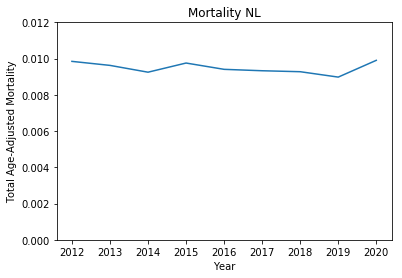

In [6]:
%matplotlib inline
plt.ylim(0,0.012)
plt.ylabel('Total Age-Adjusted Mortality')
plt.xlabel('Year')
plt.title(f'Mortality {geo}')
plt.plot(years,db2['age-adj 2020'].values());